In [39]:
# imports
import gdstk
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon

In [40]:
# load gds
lib = gdstk.read_gds(
    "C:/Users/USER/Documents/Phd/Test_Patterns-20260102T051200Z-3-001/Test_Patterns/pattern2_200_new.gds"
)

top_cell = lib.top_level()[0]
print("Top cell name:", top_cell.name)

Top cell name: TOP


In [41]:
# extract mask polygons
polygons = top_cell.get_polygons()
print("Number of polygons:", len(polygons))

MASK_LAYER = 1
MASK_DATATYPE = 0

mask_polys = []

for poly in polygons:
    if poly.layer == MASK_LAYER and poly.datatype == MASK_DATATYPE:
        mask_polys.append(poly)

print("Mask polygons found:", len(mask_polys))

Number of polygons: 3
Mask polygons found: 3


In [42]:
# rasterization
# define resolution
pixel_size_nm = 1.0            # 1 nm resolution
scale_factor = 1000.0          # µm → nm

# bounding box
bbox = top_cell.bounding_box()
min_x_um, min_y_um = bbox[0]
max_x_um, max_y_um = bbox[1]

width_um = max_x_um - min_x_um
height_um = max_y_um - min_y_um

# img size
img_width = int(np.ceil(round(width_um,5) * scale_factor))
img_height = int(np.ceil(round(height_um,5) * scale_factor))

print("Layout:", width_um, "µm ×", height_um, "µm")
print("Raster:", img_width, "×", img_height)

Layout: 1.4060000000000001 µm × 0.41 µm
Raster: 1406 × 410


In [43]:
# blank canvas
raw_mask = np.zeros((img_height, img_width), dtype=np.float32)

print("Rasterizing", len(mask_polys), "polygons")

for poly in mask_polys:
    poly_shifted = (poly.points - [min_x_um, min_y_um]) * scale_factor

    rr, cc = polygon(
        poly_shifted[:, 1],
        poly_shifted[:, 0],
        shape=raw_mask.shape
    )

    raw_mask[rr, cc] = 1.0

Rasterizing 3 polygons


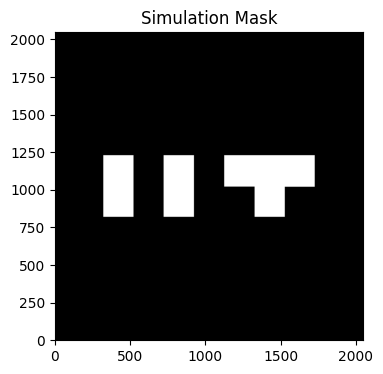

In [44]:
# Simulation window
N_sim = 1024

if img_width > N_sim or img_height > N_sim:
    print("WARNING: Enlarging simulation window")
    N_sim = 2048

# final simulation mask
mask = np.zeros((N_sim, N_sim), dtype=np.float32)

# offset to center the image
start_y = (N_sim - img_height) // 2
start_x = (N_sim - img_width) // 2

mask[
    start_y:start_y+img_height,
    start_x:start_x+img_width
] = raw_mask

plt.figure(figsize=(4, 4))
plt.imshow(mask, origin="lower", cmap="gray")
plt.title("Simulation Mask")
plt.show()

Calculating diffraction...
Simulation complete


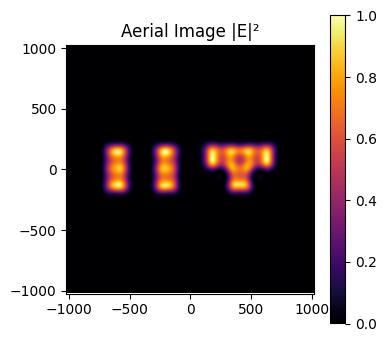

In [45]:
# Physical parameters

wavelength = 193.0      # nm
NA = 1.35
dx = pixel_size_nm

L_nm = N_sim * dx

#Grid Setup
x = np.linspace(-L_nm/2, L_nm/2, N_sim)
y = np.linspace(-L_nm/2, L_nm/2, N_sim)
X, Y = np.meshgrid(x, y)

# Frequency grid
fx = np.fft.fftfreq(N_sim, d=dx)
fy = np.fft.fftfreq(N_sim, d=dx)

FX, FY = np.meshgrid(fx, fy)
freq_radius = np.sqrt(FX**2 + FY**2)

# Cutoff frequency
f_cutoff = NA / wavelength

# Circular pupil
pupil = np.zeros_like(freq_radius)
pupil[freq_radius <= f_cutoff] = 1.0

# Forward diffraction
print("Calculating diffraction...")

mask_fft = np.fft.fft2(mask)
filtered_fft = mask_fft * pupil
field = np.fft.ifft2(filtered_fft)

# Aerial image
intensitya = np.abs(field)**2
intensitya /= intensitya.max()

print("Simulation complete")
plt.figure(figsize=(4, 4))
plt.imshow(intensitya, cmap="inferno",  extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2], origin='lower')
plt.title("Aerial Image |E|²")
plt.colorbar()
plt.show()

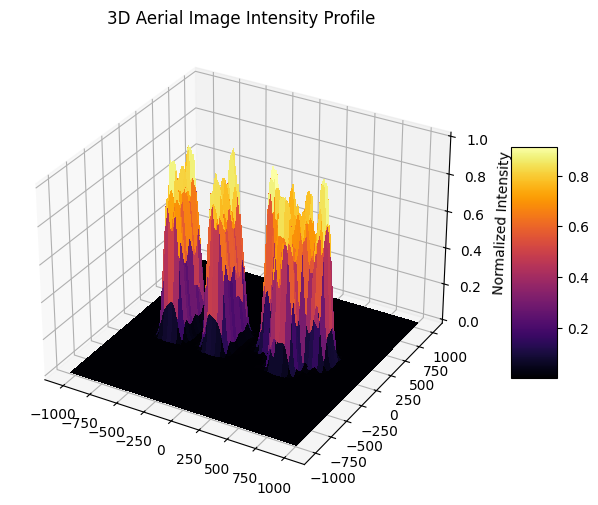

In [46]:
#3d aerial image
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, intensitya, cmap="inferno", linewidth=0, antialiased=False)

ax.set_title("3D Aerial Image Intensity Profile")
ax.set_zlabel("Normalized Intensity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [47]:
# Sigmoid resist model (Constant Threshold Resist)

def resist_sigmoid(intensity, threshold, a):
    """
    Continuous resist model used in ILT

    Parameters:
    1. intensity : 2D array
        Normalized aerial image |E|^2
    2. threshold : float
        Resist threshold (0–1)
    3. a : float
        Sigmoid steepness parameter

    Returns:
    resist : 2D array
        Continuous resist image
    """

    resist = 1.0 / (1.0 + np.exp(-a * (intensity - threshold)))
    return resist

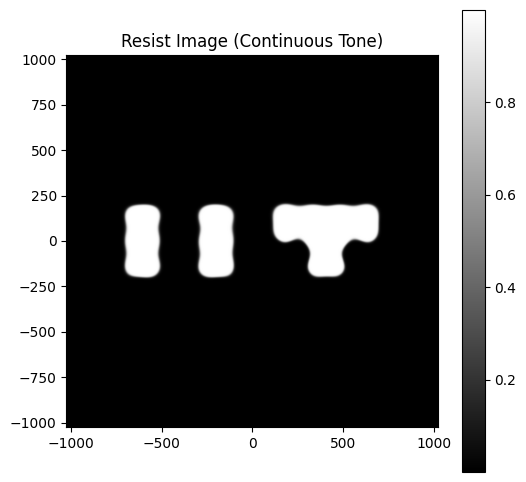

In [48]:
# Apply resist model
threshold = 0.25      # typical value
a_sigmoid = 30       # resist contrast

resist_image = resist_sigmoid(
    intensitya,
    threshold=threshold,
    a=a_sigmoid
)

plt.figure(figsize=(6,6))
plt.imshow(resist_image, cmap="gray", origin="lower", extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2])
plt.title("Resist Image (Continuous Tone)")
plt.colorbar()
plt.show()

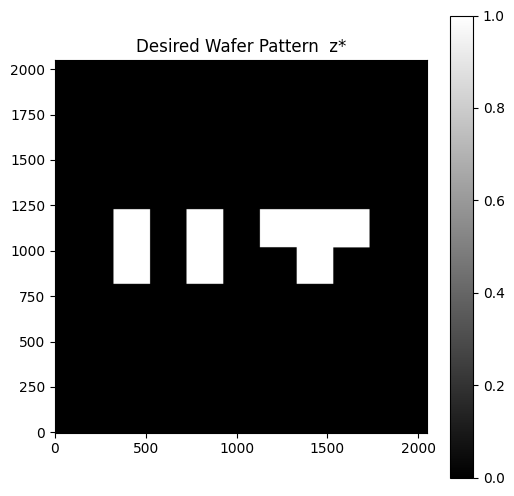

In [49]:
# Desired wafer pattern z*

z_target = mask.copy()   # usually same as layout

plt.figure(figsize=(6,6))
plt.imshow(z_target, origin="lower", cmap="gray")
plt.title("Desired Wafer Pattern  z*")
plt.colorbar()
plt.show()


In [50]:
# Cost function

def cost_function(z, z_target):
    """
    L2 wafer error
    """
    return np.sum((z - z_target)**2)


In [51]:
# STEP 1 cost: aerial image fidelity only
# Eq. (27)

def aerial_cost(mask, pupil, z_target):
    """
    J1(m) = || z* - |H m|^2 ||^2
    """

    field = np.fft.ifft2(np.fft.fft2(mask) * pupil)
    aerial = np.abs(field)**2
    #aerial /= aerial.max()

    return np.sum((z_target - aerial)**2)


In [52]:
# Sigmoid derivative

def sigmoid_derivative(z, a):
    """
    σ'(I) = a z (1 - z)
    """
    return a * z * (1.0 - z)


In [53]:
# Adjoint optical operator

def adjoint_operator(x, pupil):
    """
    H† x
    """
    X = np.fft.fft2(x)
    Y = X * pupil
    return np.fft.ifft2(Y)


In [54]:
# Analytical ILT gradient

def ilt_gradient(mask, pupil, z_target, threshold, a):
    """
    Analytical gradient of ILT cost function
    """

    # Forward optics
    mask_fft = np.fft.fft2(mask)
    field = np.fft.ifft2(mask_fft * pupil)

    intensity = np.abs(field)**2
    intensity /= intensity.max()

    # Resist
    z = resist_sigmoid(intensity, threshold, a)

    # Error term
    error = z - z_target

    # Sigmoid derivative
    dz_dI = sigmoid_derivative(z, a)

    # Chain rule term
    temp = error * dz_dI * field

    # Adjoint propagation
    grad = 2 * np.real(adjoint_operator(temp, pupil))

    return grad


In [55]:
# STEP 1 gradient (Eq. 28)

def aerial_gradient(mask, pupil, z_target):
    """
    ∇R_aerial(m)
    """

    field = np.fft.ifft2(np.fft.fft2(mask) * pupil)
    aerial = np.abs(field)**2
    #aerial /= aerial.max()

    error = z_target - aerial

    temp = error * field

    grad = -2 * np.real(
        np.fft.ifft2(np.fft.fft2(temp) * pupil)
    )

    return grad


In [56]:
# STEP 1 OPTIMIZATION

step1_iters = 80
step1_stepsize = 0.06

m = z_target.copy()   # initialization exactly as paper

step1_cost = []

for itr in range(step1_iters):

    grad = aerial_gradient(m, pupil, z_target)

    m = m - step1_stepsize * grad

    # clip only for stability
    m = np.clip(m, 0.0, 1.0)

    cost = aerial_cost(m, pupil, z_target)
    step1_cost.append(cost)

    if itr % 5 == 0:
        print(f"[STEP 1] Iter {itr:03d} | Cost = {cost:.6e}")


[STEP 1] Iter 000 | Cost = 4.546441e+04
[STEP 1] Iter 005 | Cost = 3.942821e+04
[STEP 1] Iter 010 | Cost = 3.576023e+04
[STEP 1] Iter 015 | Cost = 3.311143e+04
[STEP 1] Iter 020 | Cost = 3.116348e+04
[STEP 1] Iter 025 | Cost = 2.973512e+04
[STEP 1] Iter 030 | Cost = 2.869244e+04
[STEP 1] Iter 035 | Cost = 2.793270e+04
[STEP 1] Iter 040 | Cost = 2.737801e+04
[STEP 1] Iter 045 | Cost = 2.697059e+04
[STEP 1] Iter 050 | Cost = 2.666828e+04
[STEP 1] Iter 055 | Cost = 2.644070e+04
[STEP 1] Iter 060 | Cost = 2.626626e+04
[STEP 1] Iter 065 | Cost = 2.612963e+04
[STEP 1] Iter 070 | Cost = 2.602007e+04
[STEP 1] Iter 075 | Cost = 2.593004e+04


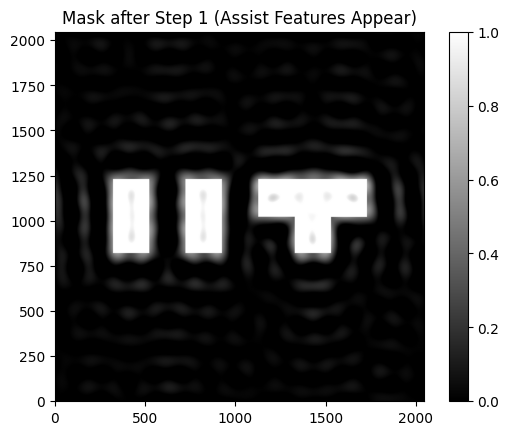

In [19]:
mask_step1 = m.copy()

plt.imshow(mask_step1, cmap="gray", origin="lower")
plt.title("Mask after Step 1 (Assist Features Appear)")
plt.colorbar()
plt.show()


In [57]:
# Parametric mask mapping
# Eq. (19)

def h_to_mask(h):
    return 0.5 * (1.0 + np.cos(h))


def dh_dm(h):
    return -0.5 * np.sin(h)


In [58]:
# Initialization

h = np.arccos(2.0 * mask_step1 - 1.0)


In [59]:
# Gradient in h-domain

def ilt_gradient_h(h, pupil, z_target, threshold, a):
    
    m = h_to_mask(h)

    grad_m = ilt_gradient(
        m,
        pupil,
        z_target,
        threshold,
        a
    )

    grad_h = grad_m * dh_dm(h)
    return grad_h


In [60]:
# Steepest descent step

def gradient_descent_step(h, grad_h, step_size):
    return h - step_size * grad_h


In [61]:
# ILT optimization loop

num_iters = 100
step_size = 10

cost_history = []

for itr in range(num_iters):

    # Current mask
    m = h_to_mask(h)

    # Forward simulation
    mask_fft = np.fft.fft2(m)
    field = np.fft.ifft2(mask_fft * pupil)

    intensity = np.abs(field)**2
    intensity /= intensity.max()

    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    # Cost
    cost = cost_function(z, z_target)
    cost_history.append(cost)

    # Gradient
    grad_h = ilt_gradient_h(
        h,
        pupil,
        z_target,
        threshold,
        a_sigmoid
    )

    # Update
    h = gradient_descent_step(h, grad_h, step_size)

    if itr % 2 == 0:
        print(f"Iteration {itr:03d} | Cost = {cost:.6e}")
h_step2 = h.copy()

Iteration 000 | Cost = 3.961324e+04
Iteration 002 | Cost = 2.710522e+04
Iteration 004 | Cost = 1.780699e+04
Iteration 006 | Cost = 1.486765e+04
Iteration 008 | Cost = 1.303641e+04
Iteration 010 | Cost = 1.154442e+04
Iteration 012 | Cost = 9.924134e+03
Iteration 014 | Cost = 9.582096e+03
Iteration 016 | Cost = 9.358729e+03
Iteration 018 | Cost = 1.008461e+04
Iteration 020 | Cost = 8.744749e+03
Iteration 022 | Cost = 9.429925e+03
Iteration 024 | Cost = 8.663431e+03
Iteration 026 | Cost = 8.925957e+03
Iteration 028 | Cost = 9.490726e+03
Iteration 030 | Cost = 8.546528e+03
Iteration 032 | Cost = 7.774700e+03
Iteration 034 | Cost = 8.524682e+03
Iteration 036 | Cost = 8.880385e+03
Iteration 038 | Cost = 8.257829e+03
Iteration 040 | Cost = 7.874051e+03
Iteration 042 | Cost = 7.758120e+03
Iteration 044 | Cost = 7.712209e+03
Iteration 046 | Cost = 8.100140e+03
Iteration 048 | Cost = 8.115668e+03
Iteration 050 | Cost = 7.866929e+03
Iteration 052 | Cost = 7.719129e+03
Iteration 054 | Cost = 7.546

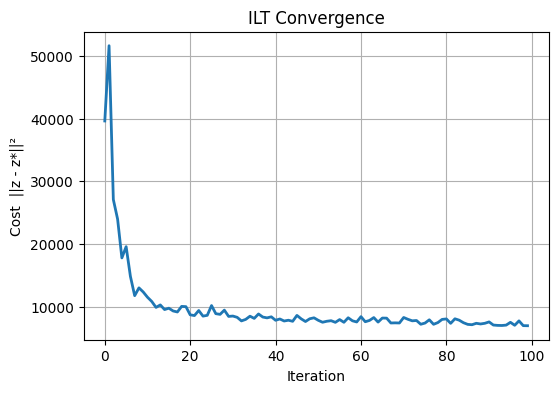

In [62]:
# Cost convergence

plt.figure(figsize=(6,4))
plt.plot(cost_history, linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Cost  ||z - z*||²")
plt.title("ILT Convergence")
plt.grid(True)
plt.show()

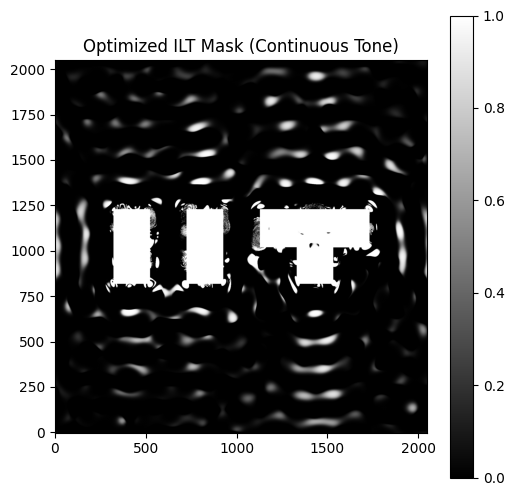

In [63]:
final_mask = h_to_mask(h)

plt.figure(figsize=(6,6))
plt.imshow(final_mask, cmap="gray", origin="lower")
plt.title("Optimized ILT Mask (Continuous Tone)")
plt.colorbar()
plt.show()


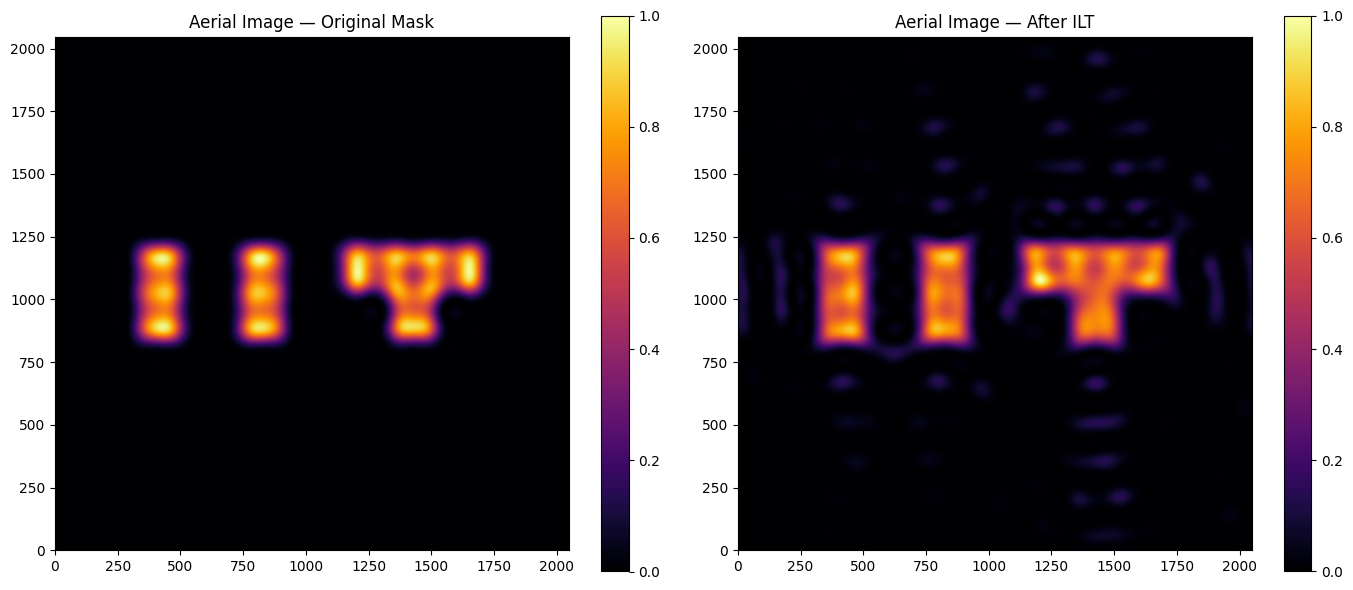

In [64]:
# Aerial image BEFORE ILT

field_orig = np.fft.ifft2(np.fft.fft2(mask) * pupil)
aerial_orig = np.abs(field_orig)**2
aerial_orig /= aerial_orig.max()

# Aerial image AFTER ILT

field_ilt = np.fft.ifft2(np.fft.fft2(final_mask) * pupil)
aerial_ilt = np.abs(field_ilt)**2
aerial_ilt /= aerial_ilt.max()

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(aerial_orig, cmap="inferno", origin="lower")
plt.title("Aerial Image — Original Mask")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(aerial_ilt, cmap="inferno", origin="lower")
plt.title("Aerial Image — After ILT")
plt.colorbar()

plt.tight_layout()
plt.show()


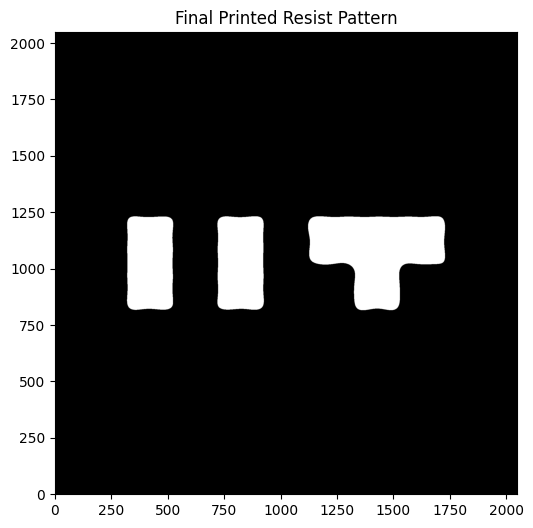

In [65]:
# continuous resist
z = resist_sigmoid(aerial_ilt, threshold=threshold, a=a_sigmoid)

# binary resist
binary_resist = np.zeros_like(z)
binary_resist[z >= 0.5] = 1.0

plt.figure(figsize=(6,6))
plt.imshow(binary_resist, cmap="gray", origin="lower")
plt.title("Final Printed Resist Pattern")
plt.show()


In [69]:
# Enhancement 1 - Aerial image penalty 3.2.3

def aerial_penalty(mask, pupil, z_target):

    field = np.fft.ifft2(np.fft.fft2(mask) * pupil)
    aerial = np.abs(field)**2

    return np.sum((z_target - aerial)**2)
def aerial_penalty_gradient(mask, pupil, z_target):

    field = np.fft.ifft2(np.fft.fft2(mask) * pupil)
    aerial = np.abs(field)**2

    error = z_target - aerial

    temp = error * np.conj(field)

    grad = -2 * np.real(
        np.fft.ifft2(np.fft.fft2(temp) * pupil)
    )

    return grad


In [70]:
# Enchancement 2 - Discretization penalty 3.2.1
def discretization_penalty(mask):
    return np.sum(4 * mask * (1 - mask))
def discretization_gradient(mask):
    return 4 * (1 - 2 * mask)


In [71]:
# Encahncement 3 - Complexity (TV) penalty 3.2.2
def tv_gradient(mask):

    dx = np.roll(mask, -1, axis=1) - mask
    dy = np.roll(mask, -1, axis=0) - mask

    grad = (
        dx - np.roll(dx, 1, axis=1)
        + dy - np.roll(dy, 1, axis=0)
    )

    return grad


In [72]:
print("\n--- Phase 2: Contour + Aerial ---")

cfid = 1.0
caerial = 0.25
cdis = 0.0
cTV = 0.0

step = 5.0
iters = 100

for itr in range(iters):

    m = h_to_mask(h)

    # forward model
    field = np.fft.ifft2(np.fft.fft2(m) * pupil)
    intensity = np.abs(field)**2
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    # ---- costs ----
    F = np.sum((z - z_target)**2)
    Ra = aerial_penalty(m, pupil, z_target)

    total_cost = cfid * F + caerial * Ra

    # ---- gradients ----
    grad = (
        cfid * ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_penalty_gradient(m, pupil, z_target)
    )

    # chain rule
    grad_h = grad * dh_dm(h)

    h -= step * grad_h

    if itr % 5 == 0:
        print(
            f"[PH2] Iter {itr:03d} | "
            f"F = {F:.4e} | "
            f"Ra = {Ra:.4e} | "
            f"Total = {total_cost:.4e}"
        )



--- Phase 2: Contour + Aerial ---
[PH2] Iter 000 | F = 3.2279e+04 | Ra = 3.5866e+04 | Total = 4.1245e+04
[PH2] Iter 005 | F = 3.1399e+04 | Ra = 3.4443e+04 | Total = 4.0010e+04
[PH2] Iter 010 | F = 3.0655e+04 | Ra = 3.3921e+04 | Total = 3.9135e+04
[PH2] Iter 015 | F = 3.0051e+04 | Ra = 3.3634e+04 | Total = 3.8459e+04
[PH2] Iter 020 | F = 2.9513e+04 | Ra = 3.3463e+04 | Total = 3.7879e+04
[PH2] Iter 025 | F = 2.9019e+04 | Ra = 3.3361e+04 | Total = 3.7359e+04
[PH2] Iter 030 | F = 2.8558e+04 | Ra = 3.3301e+04 | Total = 3.6883e+04
[PH2] Iter 035 | F = 2.8131e+04 | Ra = 3.3269e+04 | Total = 3.6448e+04
[PH2] Iter 040 | F = 2.7738e+04 | Ra = 3.3256e+04 | Total = 3.6052e+04
[PH2] Iter 045 | F = 2.7377e+04 | Ra = 3.3253e+04 | Total = 3.5690e+04
[PH2] Iter 050 | F = 2.7051e+04 | Ra = 3.3254e+04 | Total = 3.5364e+04
[PH2] Iter 055 | F = 2.6761e+04 | Ra = 3.3256e+04 | Total = 3.5074e+04
[PH2] Iter 060 | F = 2.6501e+04 | Ra = 3.3258e+04 | Total = 3.4815e+04
[PH2] Iter 065 | F = 2.6264e+04 | Ra = 3.3

In [78]:
print("\n--- Phase 3: + Discretization ---")

cdis = 0.005
step = 3.0
iters = 80

for itr in range(iters):

    m = h_to_mask(h)

    field = np.fft.ifft2(np.fft.fft2(m) * pupil)
    intensity = np.abs(field)**2
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    F = np.sum((z - z_target)**2)
    Ra = aerial_penalty(m, pupil, z_target)
    Rd = discretization_penalty(m)

    total_cost = cfid * F + caerial * Ra + cdis * Rd

    grad = (
        cfid * ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_penalty_gradient(m, pupil, z_target)
        + cdis * discretization_gradient(m)
    )

    grad_h = grad * dh_dm(h)
    h -= step * grad_h

    if itr % 5 == 0:
        print(
            f"[PH3] Iter {itr:03d} | "
            f"F = {F:.4e} | "
            f"Ra = {Ra:.4e} | "
            f"Rd = {Rd:.4e} | "
            f"Total = {total_cost:.4e}"
        )



--- Phase 3: + Discretization ---
[PH3] Iter 000 | F = 2.4429e+04 | Ra = 3.3410e+04 | Rd = 4.3483e+05 | Total = 3.4955e+04
[PH3] Iter 005 | F = 2.4090e+04 | Ra = 3.3450e+04 | Rd = 3.9410e+05 | Total = 3.4423e+04
[PH3] Iter 010 | F = 2.3903e+04 | Ra = 3.3497e+04 | Rd = 3.5835e+05 | Total = 3.4069e+04
[PH3] Iter 015 | F = 2.3826e+04 | Ra = 3.3536e+04 | Rd = 3.2627e+05 | Total = 3.3841e+04
[PH3] Iter 020 | F = 2.3808e+04 | Ra = 3.3568e+04 | Rd = 2.9703e+05 | Total = 3.3685e+04
[PH3] Iter 025 | F = 2.3810e+04 | Ra = 3.3598e+04 | Rd = 2.7011e+05 | Total = 3.3560e+04
[PH3] Iter 030 | F = 2.3819e+04 | Ra = 3.3626e+04 | Rd = 2.4522e+05 | Total = 3.3452e+04
[PH3] Iter 035 | F = 2.3832e+04 | Ra = 3.3652e+04 | Rd = 2.2217e+05 | Total = 3.3356e+04
[PH3] Iter 040 | F = 2.3846e+04 | Ra = 3.3676e+04 | Rd = 2.0082e+05 | Total = 3.3270e+04
[PH3] Iter 045 | F = 2.3861e+04 | Ra = 3.3697e+04 | Rd = 1.8108e+05 | Total = 3.3191e+04
[PH3] Iter 050 | F = 2.3876e+04 | Ra = 3.3716e+04 | Rd = 1.6287e+05 | Total

In [79]:
print("\n--- Phase 4: + TV ---")

cTV = 0.005
step = 1.5
iters = 80

for itr in range(iters):

    m = h_to_mask(h)

    field = np.fft.ifft2(np.fft.fft2(m) * pupil)
    intensity = np.abs(field)**2
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    F  = np.sum((z - z_target)**2)
    Ra = aerial_penalty(m, pupil, z_target)
    Rd = discretization_penalty(m)
    Rt = np.sum(np.abs(tv_gradient(m)))

    total_cost = cfid * F + caerial * Ra + cdis * Rd + cTV * Rt

    grad = (
        cfid * ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_penalty_gradient(m, pupil, z_target)
        + cdis * discretization_gradient(m)
        + cTV * tv_gradient(m)
    )

    grad_h = grad * dh_dm(h)
    h -= step * grad_h

    if itr % 5 == 0:
        print(
            f"[PH4] Iter {itr:03d} | "
            f"F = {F:.4e} | "
            f"Ra = {Ra:.4e} | "
            f"Rd = {Rd:.4e} | "
            f"TV = {Rt:.4e} | "
            f"Total = {total_cost:.4e}"
        )



--- Phase 4: + TV ---
[PH4] Iter 000 | F = 2.3953e+04 | Ra = 3.3779e+04 | Rd = 8.1707e+04 | TV = 7.1959e+04 | Total = 3.3166e+04
[PH4] Iter 005 | F = 2.3960e+04 | Ra = 3.3780e+04 | Rd = 7.6717e+04 | TV = 7.2717e+04 | Total = 3.3152e+04
[PH4] Iter 010 | F = 2.3966e+04 | Ra = 3.3782e+04 | Rd = 7.1974e+04 | TV = 7.3490e+04 | Total = 3.3139e+04
[PH4] Iter 015 | F = 2.3971e+04 | Ra = 3.3784e+04 | Rd = 6.7468e+04 | TV = 7.4276e+04 | Total = 3.3126e+04
[PH4] Iter 020 | F = 2.3976e+04 | Ra = 3.3785e+04 | Rd = 6.3192e+04 | TV = 7.5076e+04 | Total = 3.3113e+04
[PH4] Iter 025 | F = 2.3980e+04 | Ra = 3.3786e+04 | Rd = 5.9138e+04 | TV = 7.5886e+04 | Total = 3.3102e+04
[PH4] Iter 030 | F = 2.3984e+04 | Ra = 3.3788e+04 | Rd = 5.5296e+04 | TV = 7.6708e+04 | Total = 3.3090e+04
[PH4] Iter 035 | F = 2.3987e+04 | Ra = 3.3789e+04 | Rd = 5.1660e+04 | TV = 7.7540e+04 | Total = 3.3080e+04
[PH4] Iter 040 | F = 2.3990e+04 | Ra = 3.3790e+04 | Rd = 4.8220e+04 | TV = 7.8380e+04 | Total = 3.3070e+04
[PH4] Iter 045

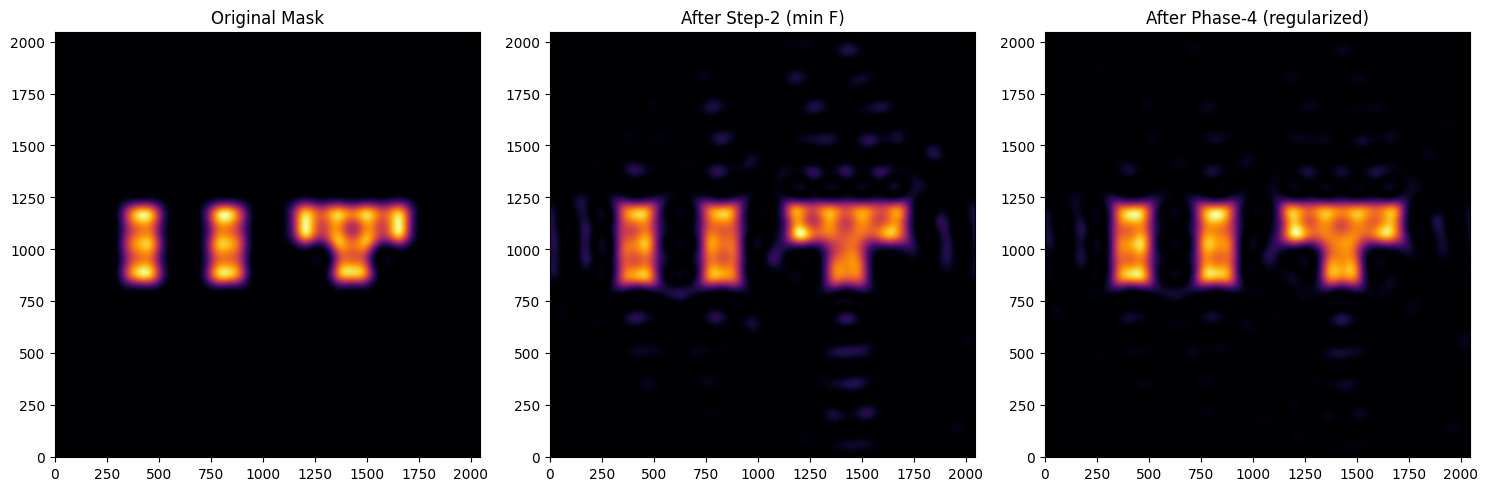

In [84]:
mask_orig   = mask.copy()
mask_step2  = h_to_mask(h_step2)   # save h before phase-3
mask_final  = h_to_mask(h)         # after phase-4


def aerial_from_mask(m):
    field = np.fft.ifft2(np.fft.fft2(m) * pupil)
    I = np.abs(field)**2
    return I / I.max()


I_orig  = aerial_from_mask(mask_orig)
I_s2    = aerial_from_mask(mask_step2)
I_final = aerial_from_mask(mask_final)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(I_orig, cmap="inferno", origin='lower')
plt.title("Original Mask")

plt.subplot(1,3,2)
plt.imshow(I_s2, cmap="inferno", origin='lower')
plt.title("After Step-2 (min F)")

plt.subplot(1,3,3)
plt.imshow(I_final, cmap="inferno", origin='lower')
plt.title("After Phase-4 (regularized)")

plt.tight_layout()
plt.show()


In [81]:
def contrast(I):
    return (I.max() - I.min()) / (I.max() + I.min())

print("Contrast:")
print("Original :", contrast(I_orig))
print("Step-2   :", contrast(I_s2))
print("Phase-4  :", contrast(I_final))


Contrast:
Original : 0.9999999999999999
Step-2   : 1.0
Phase-4  : 0.9999999999999885


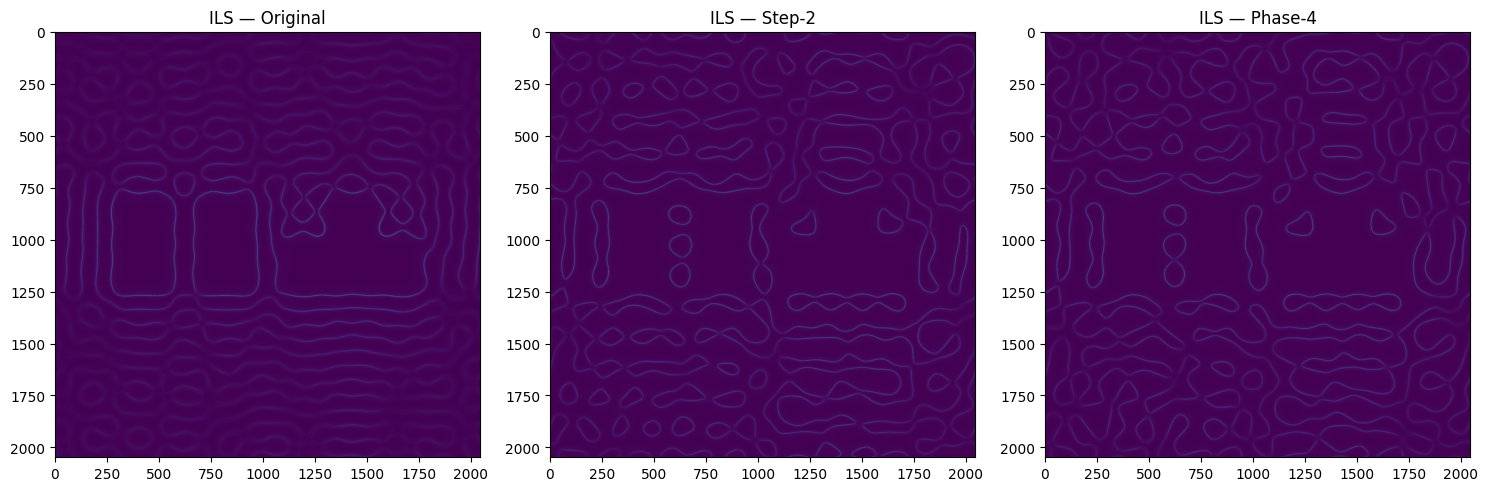

In [82]:
def ils(I, eps=1e-6):
    gx, gy = np.gradient(I)
    grad = np.sqrt(gx**2 + gy**2)
    return grad / (I + eps)

ILS_orig  = ils(I_orig)
ILS_s2    = ils(I_s2)
ILS_final = ils(I_final)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(ILS_orig, cmap="viridis")
plt.title("ILS — Original")

plt.subplot(1,3,2)
plt.imshow(ILS_s2, cmap="viridis")
plt.title("ILS — Step-2")

plt.subplot(1,3,3)
plt.imshow(ILS_final, cmap="viridis")
plt.title("ILS — Phase-4")

plt.tight_layout()
plt.show()


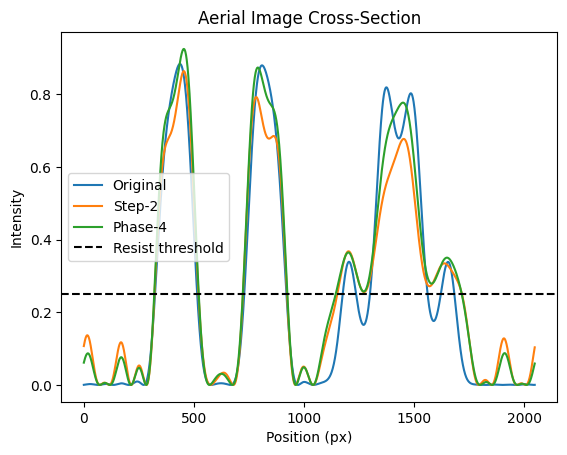

In [83]:
row = N_sim // 2

plt.plot(I_orig[row],  label="Original")
plt.plot(I_s2[row],    label="Step-2")
plt.plot(I_final[row], label="Phase-4")

plt.axhline(threshold, color="k", linestyle="--", label="Resist threshold")

plt.legend()
plt.title("Aerial Image Cross-Section")
plt.xlabel("Position (px)")
plt.ylabel("Intensity")
plt.show()
